## Simulating melts of polymer chains

In [1]:
import warnings
warnings.filterwarnings('ignore')
import hoomd
import gsd
import gsd.hoomd
from hoomd.md import nlist

import unyt as u
import glob
import mbuild as mb
import matplotlib.pyplot as plt
import numpy as np

import flowermd
from flowermd.utils import get_target_box_mass_density
from flowermd.base import Simulation, Molecule
from flowermd.library import FF_from_file
from flowermd.base.system import Pack

from polymer_dictionary import bond_indices

# Rerun with the original seed first

In [2]:
# Updates atom names to fit with hoomd conventions
def espaloma_mol(file_path):
     mol = mb.load(file_path)
     for p in mol.particles():
           p.name = f"_{p.name}"
     return mol

## Single molecule sim:

In [48]:
system_file = '/home/jbieri/CME_lab/repos/pl-validation/mol2/fixed_PCPDTPT_nC16_2mer.mol2'
# system_file = '/home/jbieri/CME_lab/repos/pl-validation/mol2/fixed_PCPDTPT_nC16.mol2'
ff_filepath = '/home/jbieri/CME_lab/repos/pl-validation/xml/fixed_PCPDTPT_nC16.xml'

espmol = espaloma_mol(system_file)
molecule = Molecule(num_mols=1, compound=espmol)

molff = FF_from_file(ff_filepath)
system = Pack(molecules=molecule,density=0.01 * u.g/u.cm**3,packing_expand_factor=5)
system.apply_forcefield(r_cut=2.5, force_field=molff, auto_scale=True,remove_charges=True, remove_hydrogens=True)

ParameterizationError: No parameters found for connection <Dihedral Dihedral, id: 139782542540176> , group: dihedral_type, identifiers: [['N2', 'C0', 'C0', 'S1'], ['N2', 'C0', 'C0', 'S1']] in the Forcefield.

In [45]:
system.hoomd_snapshot
hoomd_forces = system.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()
sim = Simulation.from_system(system=system, gsd_write_freq=1000, log_write_freq=1000, device=cpu, gsd_file_name='fixed_PCPDTPT_nC16_melt.gsd',log_file_name="fixed_log.txt")

Initializing simulation state from a gsd.hoomd.Frame.


In [46]:
target_box = flowermd.utils.get_target_box_mass_density(density=0.02 * u.g/u.cm**3, mass=sim.mass.to("g"))
sim.run_update_volume(n_steps=1e4, kT=1.0, tau_kt=1.0, final_box_lengths=target_box, period=10)

Step 1000 of 10000; TPS: 2575.53; ETA: 0.1 minutes
Step 2000 of 10000; TPS: 3935.24; ETA: 0.0 minutes
Step 3000 of 10000; TPS: 4939.73; ETA: 0.0 minutes
Step 4000 of 10000; TPS: 5639.12; ETA: 0.0 minutes
Step 5000 of 10000; TPS: 6177.35; ETA: 0.0 minutes
Step 6000 of 10000; TPS: 6495.8; ETA: 0.0 minutes
Step 7000 of 10000; TPS: 6814.72; ETA: 0.0 minutes
Step 8000 of 10000; TPS: 7066.26; ETA: 0.0 minutes
Step 9000 of 10000; TPS: 7236.29; ETA: 0.0 minutes
Step 10000 of 10000; TPS: 7146.84; ETA: 0.0 minutes


In [47]:
sim.run_NVT(n_steps=1e4, kT=5.0, tau_kt=1.0)
sim.flush_writers()

Step 999 of 10000; TPS: 6952.85; ETA: 0.0 minutes
Step 1999 of 10000; TPS: 7812.68; ETA: 0.0 minutes
Step 2999 of 10000; TPS: 8404.37; ETA: 0.0 minutes
Step 3999 of 10000; TPS: 8486.18; ETA: 0.0 minutes
Step 4999 of 10000; TPS: 8668.74; ETA: 0.0 minutes
Step 5999 of 10000; TPS: 8925.5; ETA: 0.0 minutes
Step 6999 of 10000; TPS: 9110.74; ETA: 0.0 minutes
Step 7999 of 10000; TPS: 9151.01; ETA: 0.0 minutes
Step 8999 of 10000; TPS: 9154.07; ETA: 0.0 minutes
Step 9999 of 10000; TPS: 9252.41; ETA: 0.0 minutes


In [24]:
sim.reference_values

{'energy': unyt_quantity(1.046, 'kJ/mol'),
 'length': unyt_quantity(0.35635949, 'nm'),
 'mass': unyt_quantity(32.06, 'amu')}

In [22]:
data = np.genfromtxt("5_fixed_log.txt", names=True)
pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
ke = data["mdcomputeThermodynamicQuantitieskinetic_energy"]
ts = data["flowermdbasesimulationSimulationtimestep"]
energies = {"Potential energy (kJ/mol)":pe, "Kinetic energy (kJ/mol)":ke}

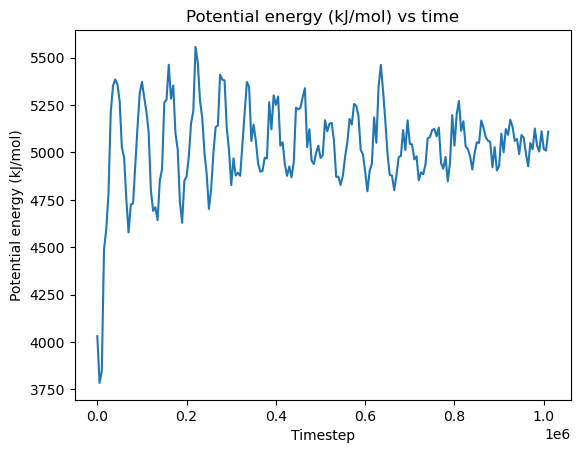

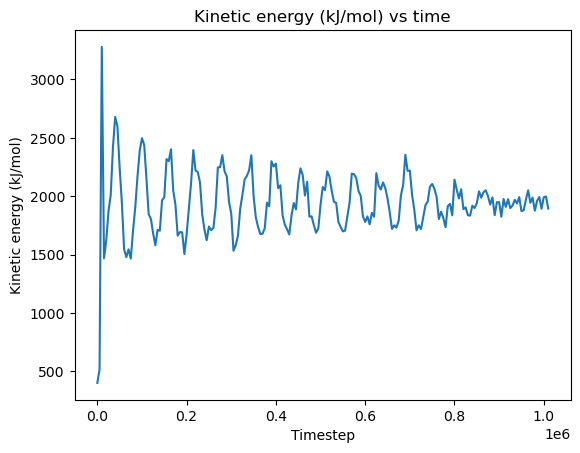

In [23]:
for energy in energies:
    plt.figure()
    plt.plot(ts,energies[energy])
    plt.xlabel("Timestep")
    plt.ylabel(energy)
    plt.title(energy +" vs time")